In [28]:
# Step 1: Import Libraries
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

In [29]:
# Step 2: Load and Explore Dataset
video_data = pd.read_csv("Kaggle_TED_video_metadata_balanced.csv")

for column in video_data.columns:
    if video_data[column].isnull().any():
        if video_data[column].dtype == 'object':
            video_data[column] = video_data[column].fillna(video_data[column].mode()[0])
        else:
            video_data[column] = video_data[column].fillna(video_data[column].median())


In [30]:
# Step 3: Feature Engineering
video_data['log_views'] = np.log1p(video_data['views'])
video_data['log_likes'] = np.log1p(video_data['likes'])
video_data['log_comments'] = np.log1p(video_data['comment_count'])


In [31]:
# Step 4: Outlier Removal BEFORE Feature Engineering
features_to_use = ['log_views', 'log_likes', 'log_comments']
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(video_data[features_to_use])
video_data_filtered = video_data[outliers == 1].copy()


In [32]:
# Step 5: Feature Transformation
scaler = StandardScaler()
df_scaled_filtered = scaler.fit_transform(video_data_filtered[features_to_use])


In [33]:
# Step 6: Apply KMeans Clustering on video_data_filtered
kmeans = KMeans(n_clusters=2, random_state=42, n_init=20, max_iter=300)
video_data_filtered['cluster_label'] = kmeans.fit_predict(df_scaled_filtered)

log_views_threshold = video_data_filtered['log_views'].quantile(0.6)
video_data_filtered['cluster_name'] = np.where(video_data_filtered['log_views'] >= log_views_threshold, 'Popular', 'Not Popular')

In [34]:
# Step 7: Calculate Silhouette Score
silhouette_avg = silhouette_score(df_scaled_filtered, video_data_filtered['cluster_label'])
print(f"\nInitial Silhouette Score for n_clusters=2: {silhouette_avg:.4f}")



Initial Silhouette Score for n_clusters=2: 0.5130


In [35]:
# Step 8: Balancing Clusters Dynamically with 60/40 Ratio
popular_size = int(0.6 * len(video_data_filtered))
not_popular_size = len(video_data_filtered) - popular_size

balanced_video_data = pd.DataFrame()
for label in ['Popular', 'Not Popular']:
    cluster_data = video_data_filtered[video_data_filtered['cluster_name'] == label]
    target_size = popular_size if label == 'Popular' else not_popular_size
    replace_sampling = len(cluster_data) < target_size
    balanced_cluster = resample(cluster_data, replace=replace_sampling, n_samples=target_size, random_state=42)
    balanced_video_data = pd.concat([balanced_video_data, balanced_cluster])

balanced_video_data = balanced_video_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [36]:
# Step 10: Fit KMeans Again to Balanced Dataset
df_balanced_scaled = scaler.transform(balanced_video_data[features_to_use])
balanced_kmeans = KMeans(n_clusters=2, random_state=42, n_init=50, max_iter=500)
balanced_video_data['cluster_label'] = balanced_kmeans.fit_predict(df_balanced_scaled)

balanced_video_data['cluster_name'] = np.where(balanced_video_data['log_views'] >= log_views_threshold, 'Popular', 'Not Popular')

In [37]:
# Step 11: Calculate Silhouette Score for Balanced Data
final_silhouette_avg = silhouette_score(df_balanced_scaled, balanced_video_data['cluster_label'])
print(f"\nFinal Silhouette Score for n_clusters=2: {final_silhouette_avg:.4f}")

# Step 12: Verify Cluster Balance
final_cluster_counts = balanced_video_data['cluster_name'].value_counts()
print("\nFinal Cluster Counts:")
print(final_cluster_counts)



Final Silhouette Score for n_clusters=2: 0.5175

Final Cluster Counts:
cluster_name
Popular        342
Not Popular    228
Name: count, dtype: int64


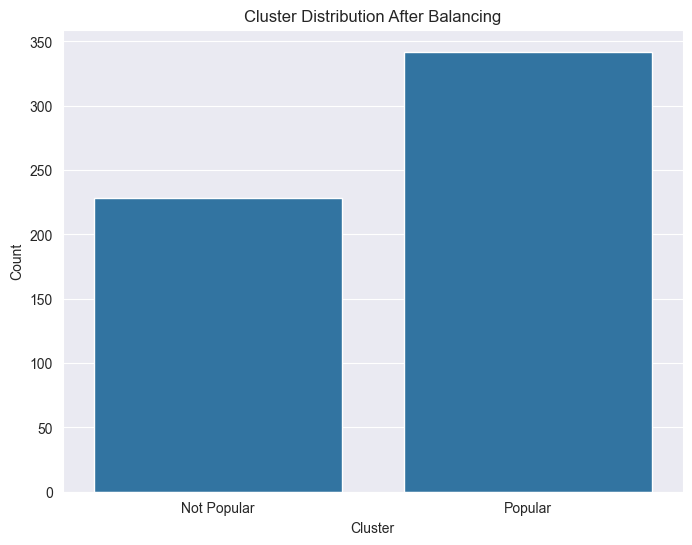

In [38]:
# Step 14: Plot Cluster Distribution Bar Chart
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster_name', data=balanced_video_data)
plt.title('Cluster Distribution After Balancing')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

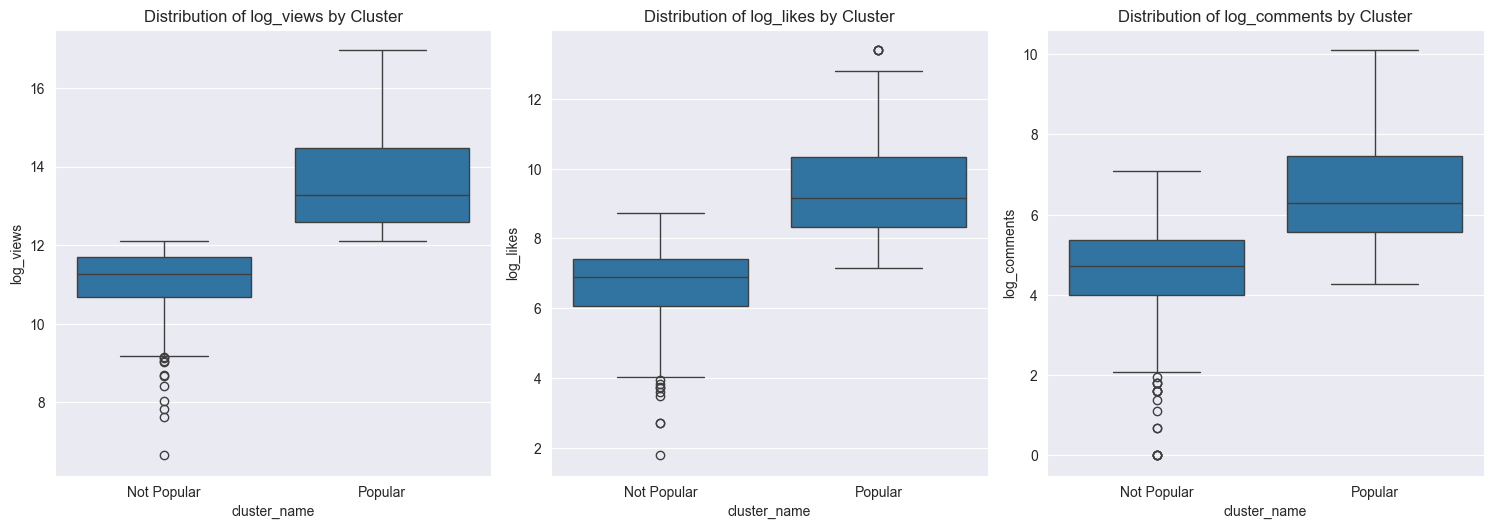

In [39]:
# Step 14: Boxplot for Each Feature by Cluster to Visualize Differences
plt.figure(figsize=(20, 10))
for index, column in enumerate(features_to_use):
    plt.subplot(2, 4, index + 1)
    sns.boxplot(x='cluster_name', y=column, data=balanced_video_data)
    plt.title(f'Distribution of {column} by Cluster')
plt.tight_layout()
plt.show()

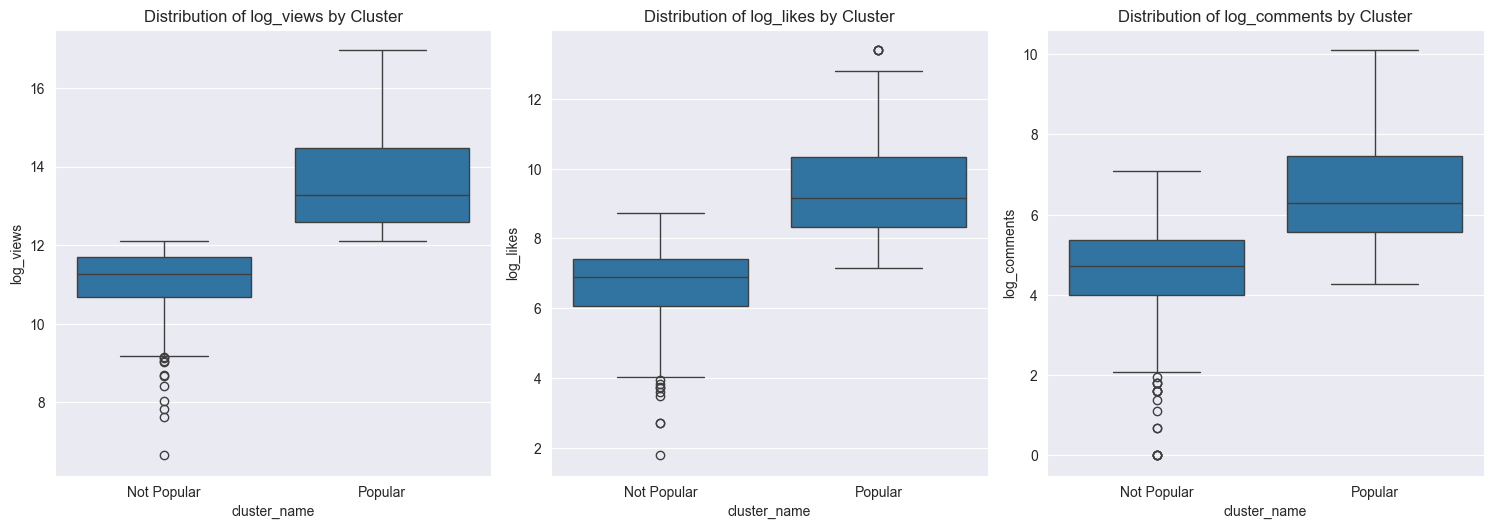

In [40]:
# Step 15: Scatter Plot of Clusters Based on Views and Likes
plt.figure(figsize=(20, 10))
for index, column in enumerate(features_to_use):
    plt.subplot(2, 4, index + 1)
    sns.boxplot(x='cluster_name', y=column, data=balanced_video_data)
    plt.title(f'Distribution of {column} by Cluster')
plt.tight_layout()
plt.show()

In [41]:
joblib.dump(balanced_kmeans, 'kmeans_ted_model_balanced.pkl')
joblib.dump(df_balanced_scaled, 'scaler_ted_model_balanced.pkl')

['scaler_ted_model_balanced.pkl']